In [1]:
%load_ext autoreload
%autoreload 2

from multiprocessing import Pool

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from funcoes import limpa_html
from funcoesnlp import token_lemma, add_bigram, create_dictionary, create_corpus, ModelLDA, calc_coherence, stop

In [2]:
df = pd.read_feather('scielo_dataset.feather')

In [3]:
df.head()

,title,seção,ano,doi_id,text_html
0,"""... E o XIV SNEF aconteceu""",editorial,2001,10.1590/S1806-11172001000200001,"<!DOCTYPE html>\n<div class=""articleTxt"">\n <d..."
1,Carta ao editor,carta ao editor,2001,10.1590/S1806-11172001000200002,"<!DOCTYPE html>\n<div class=""articleTxt"">\n <d..."
2,Pontos quânticos: átomos artificiais e transis...,SEM CATEGORIA,2001,10.1590/S1806-11172001000200004,"<!DOCTYPE html>\n<div class=""articleTxt"">\n <d..."
3,As equações de Hamilton sem transformação de L...,SEM CATEGORIA,2001,10.1590/S1806-11172001000200005,"<!DOCTYPE html>\n<div class=""articleTxt"">\n <d..."
4,Um experimento de oscilador forçado amortecido,SEM CATEGORIA,2001,10.1590/S1806-11172001000200006,"<!DOCTYPE html>\n<div class=""articleTxt"">\n <d..."


In [4]:
remover = ['didactic resources', 'articles', 'physics education research']
df = df.query('seção not in @remover')

In [5]:
replace_dict = {
    'cartas ao editor': 'carta ao editor',
    'carta do editor': 'carta ao editor',
    'resenha': 'resenhas',
    'resenhas de livros': 'resenhas',
    'tipo de artigo': 'artigos gerais'
}

df['seção'] = df['seção'].replace(replace_dict)

In [6]:
with Pool() as pool:
    textos = list(tqdm(pool.imap(limpa_html, df['text_html']), total=len(df)))
    
with Pool() as pool:
    documentos = list(tqdm(pool.imap(token_lemma, textos), total=len(textos)))

del textos

  0%|          | 0/1664 [00:00<?, ?it/s]

  0%|          | 0/1664 [00:00<?, ?it/s]

In [7]:
add_bigram(documentos, min_count=5)
dicionario = create_dictionary(documentos, no_below=0.1, no_above=0.6)
corpus = create_corpus(dicionario, documentos)

In [8]:
lda = ModelLDA(corpus, dicionario)

In [9]:
n_topicos = list(range(2, 21))
with Pool() as pool:
    modelos = list(tqdm(pool.imap(lda.run, n_topicos), total=len(n_topicos)))

  0%|          | 0/19 [00:00<?, ?it/s]

In [10]:
coerencias = {'u_mass': [],
              'c_v': [],
              'c_uci': [],
              'c_npmi': []}

for modelo in tqdm(modelos):
    for coe in tqdm(coerencias.keys(), leave=False):
        coerencias[coe].append(calc_coherence(modelo, documentos, dicionario, corpus, coe))

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [18]:
def plot_coerencias(coerencias):
    fig, ax = plt.subplots(nrows=1, ncols=len(coerencias),
                           figsize=(5*len(coerencias), 5))

    for i, k in enumerate(coerencias):
        y = coerencias[k]

        ax[i].set_title(k)
        ax[i].set_xlabel('Número de tópicos')

        ax[i].scatter(n_topicos, y, s=16, c='black')
        ax[i].plot(n_topicos, y, c='black', ls='--')

    fig.tight_layout()
    plt.show()

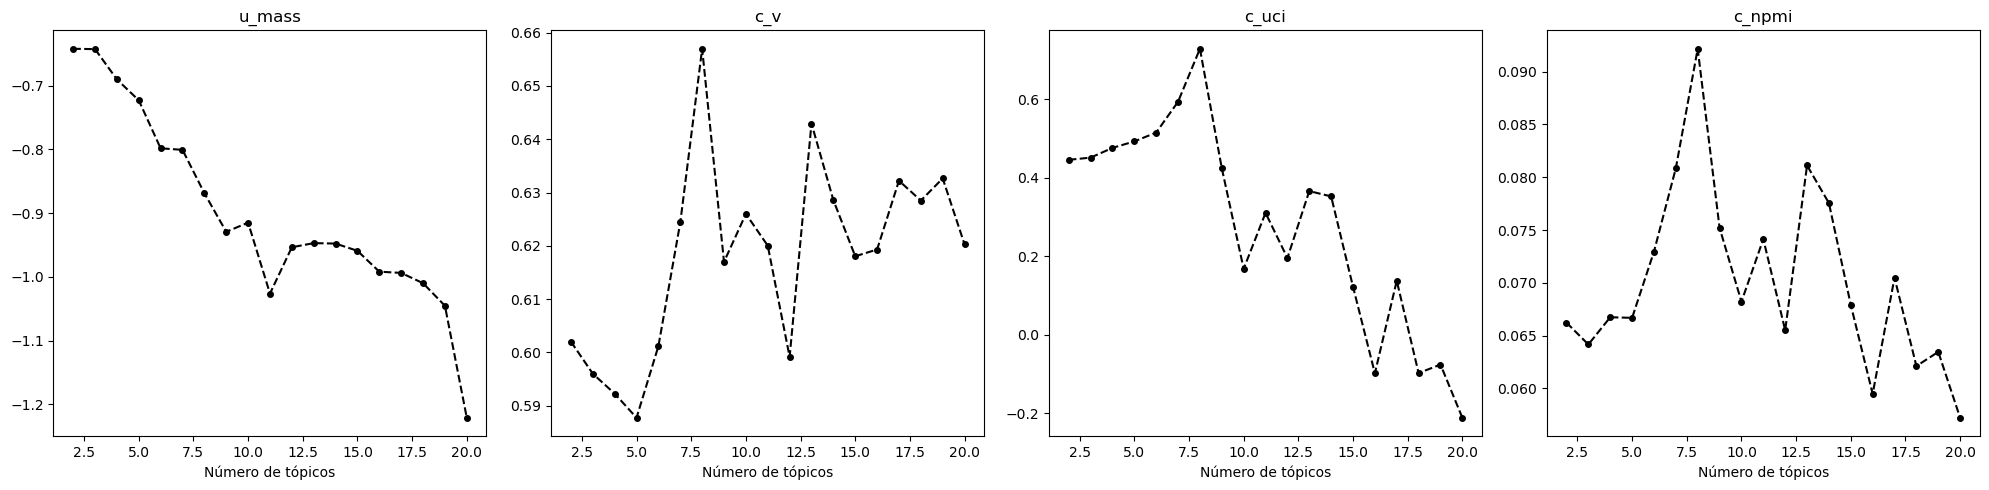

In [19]:
plot_coerencias(coerencias)

In [20]:
norm_coerencias = {}
for k, v in coerencias.items():
    x = np.array(v)
    norm_coerencias[k] = (x - min(x)) / (max(x) - min(x))

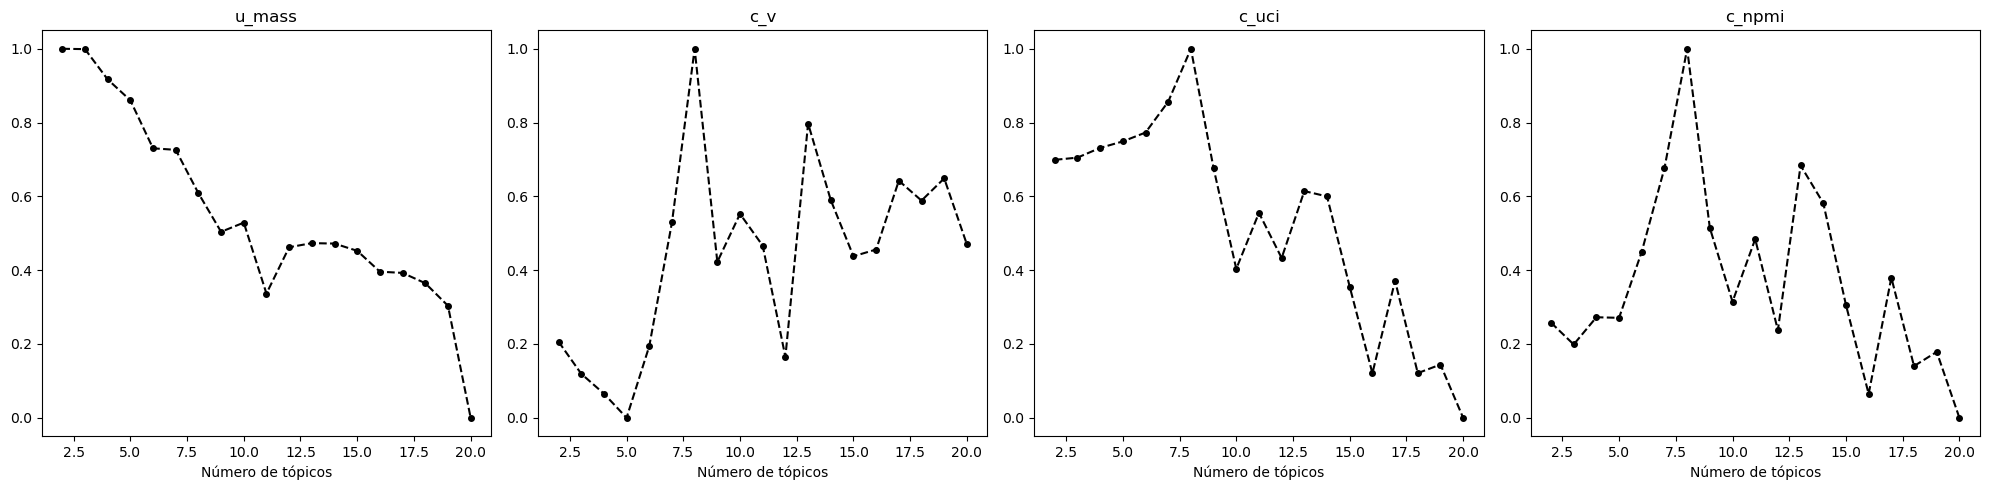

In [45]:
plot_coerencias(norm_coerencias)

In [22]:
medias = sum(norm_coerencias.values()) / len(norm_coerencias)

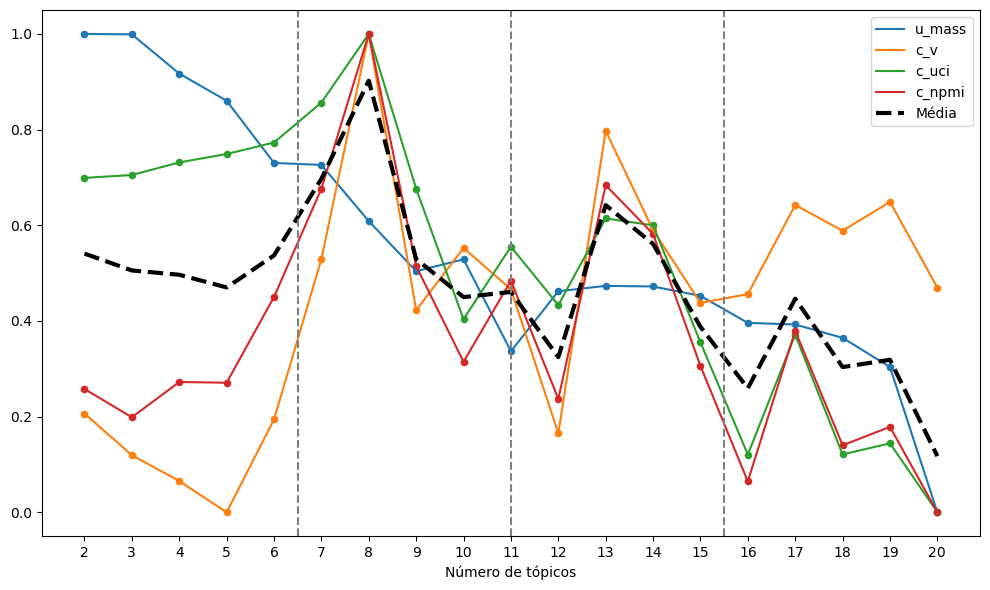

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlabel('Número de tópicos')

for i, k in enumerate(norm_coerencias):
    y = norm_coerencias[k]
    ax.scatter(n_topicos, y, s=20)
    ax.plot(n_topicos, y, label=k)

ax.plot(n_topicos, medias, label='Média', c='k', lw=3, ls='--')

n = 4
dx = (max(n_topicos) - min(n_topicos)) / n
for i in range(1, n):
    ax.axvline(min(n_topicos)+i*dx, ls='--', c='gray')

ax.set_xticks(n_topicos)
ax.legend()
fig.tight_layout()
plt.show()

In [24]:
for i in medias.argsort()[::-1]:
    print(f'{str(n_topicos[i]).rjust(2, "0")} tópicos | {medias[i]:.2f}')

08 tópicos | 0.90
07 tópicos | 0.70
13 tópicos | 0.64
14 tópicos | 0.56
02 tópicos | 0.54
06 tópicos | 0.54
09 tópicos | 0.53
03 tópicos | 0.51
04 tópicos | 0.50
05 tópicos | 0.47
11 tópicos | 0.46
10 tópicos | 0.45
17 tópicos | 0.45
15 tópicos | 0.39
12 tópicos | 0.32
19 tópicos | 0.32
18 tópicos | 0.30
16 tópicos | 0.26
20 tópicos | 0.12


In [25]:
model = modelos[8-min(n_topicos)]

In [27]:
model.print_topics(num_words=15)

[(0,
  '0.014*"campo" + 0.008*"onda" + 0.008*"solução" + 0.007*"potencial" + 0.006*"magnético" + 0.005*"partícula" + 0.005*"elétrico" + 0.004*"carga" + 0.004*"espaço" + 0.004*"quântico" + 0.004*"vetor" + 0.004*"fase" + 0.004*"ordem" + 0.004*"termo" + 0.004*"operador"'),
 (1,
  '0.009*"ano" + 0.008*"curso" + 0.007*"pesquisa" + 0.006*"universidade" + 0.006*"ciência" + 0.006*"brasil" + 0.005*"científico" + 0.005*"brasileiro" + 0.004*"professor" + 0.003*"projeto" + 0.003*"instituto" + 0.003*"publicar" + 0.003*"formação" + 0.003*"país" + 0.003*"rio"'),
 (2,
  '0.017*"sol" + 0.016*"estrela" + 0.016*"terra" + 0.015*"solar" + 0.011*"planeta" + 0.007*"lua" + 0.006*"magnético" + 0.006*"órbita" + 0.006*"região" + 0.005*"distância" + 0.005*"centro" + 0.005*"astronomia" + 0.005*"observação" + 0.005*"dia" + 0.005*"ano"'),
 (3,
  '0.018*"temperatura" + 0.015*"partícula" + 0.010*"radiação" + 0.007*"calor" + 0.007*"interação" + 0.007*"átomo" + 0.006*"massa" + 0.006*"elétrons" + 0.005*"gás" + 0.005*"tér

In [28]:
df['topico'] = [max(model.get_document_topics(corpu), key=lambda x: x[1])[0] for corpu in corpus]

In [29]:
pd.crosstab(df['seção'], df['topico'])

topico,0,1,2,3,4,5,6,7
seção,,,,,,,,
SEM CATEGORIA,7,2,0,1,3,0,0,3
ano internacional da luz,0,0,0,2,0,0,0,4
artigos de einstein e ensaios sobre sua obra,2,0,0,3,0,0,0,8
artigos de revisão sobre relatividade geral e cosmologia,1,0,0,0,0,0,0,3
artigos gerais,344,6,52,71,177,50,26,81
carta ao editor,7,11,0,3,0,0,12,5
desenvolvimento em ensino de física,2,1,2,2,35,5,27,4
editorial,0,8,0,0,0,0,7,2
errata,2,2,0,1,2,1,1,0


In [30]:
topicos_dict = df.groupby('ano')['topico'].value_counts().unstack().to_dict()

In [31]:
topicos_ = {}
for topico in topicos_dict:
    for ano, valor in topicos_dict[topico].items():
        valor = 0 if np.isnan(valor) else int(valor)
        try:
            topicos_[ano].append(valor)
        except KeyError:
            topicos_[ano] = [valor]

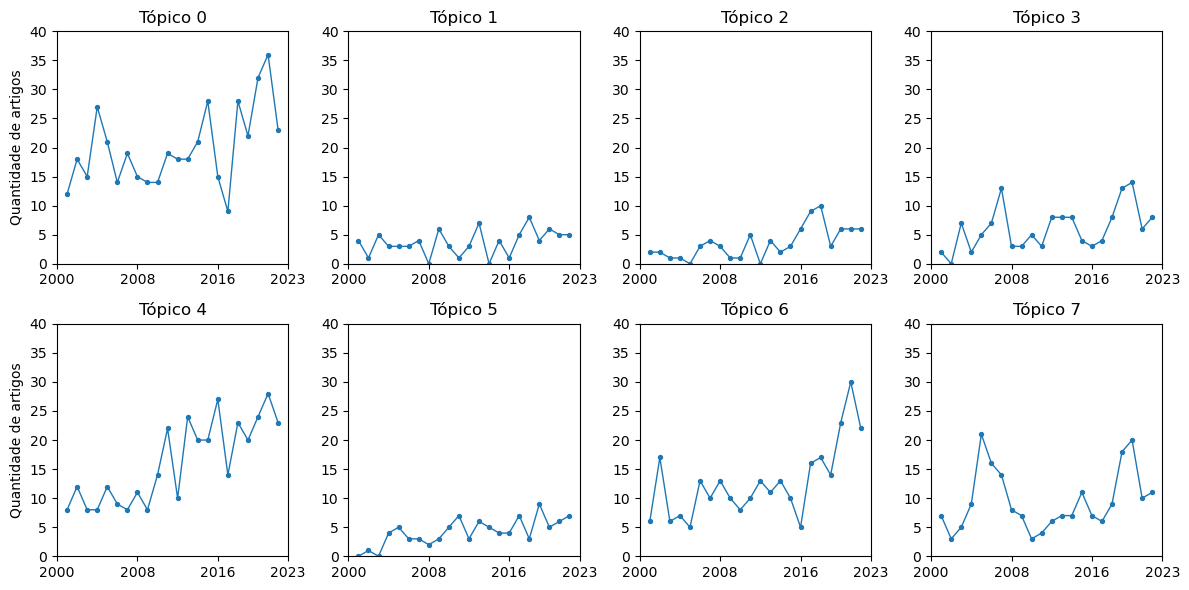

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=4,
                           figsize=(12, 6))
for topico in topicos_dict:
    i, j = topico//4, topico%4
    ax[i, j].set_title(f'Tópico {topico}')
    if i == 3:
        ax[i, j].set_xlabel('Anos')
    if j == 0:
        ax[i, j].set_ylabel('Quantidade de artigos')
    
    dados = topicos_dict[topico]
    anos, frequencia = dados.keys(), dados.values()
    freq = np.array(list(frequencia))
    freq[np.isnan(freq)] = 0
    ax[i, j].scatter(anos, freq, s=8)
    ax[i, j].plot(anos, freq, lw=1)
    ax[i, j].set_xlim(2000, 2023)
    ax[i, j].set_xticks([2000, 2008, 2016, 2023])
    ax[i, j].set_ylim(0, 40)
    
fig.tight_layout()
plt.show() 

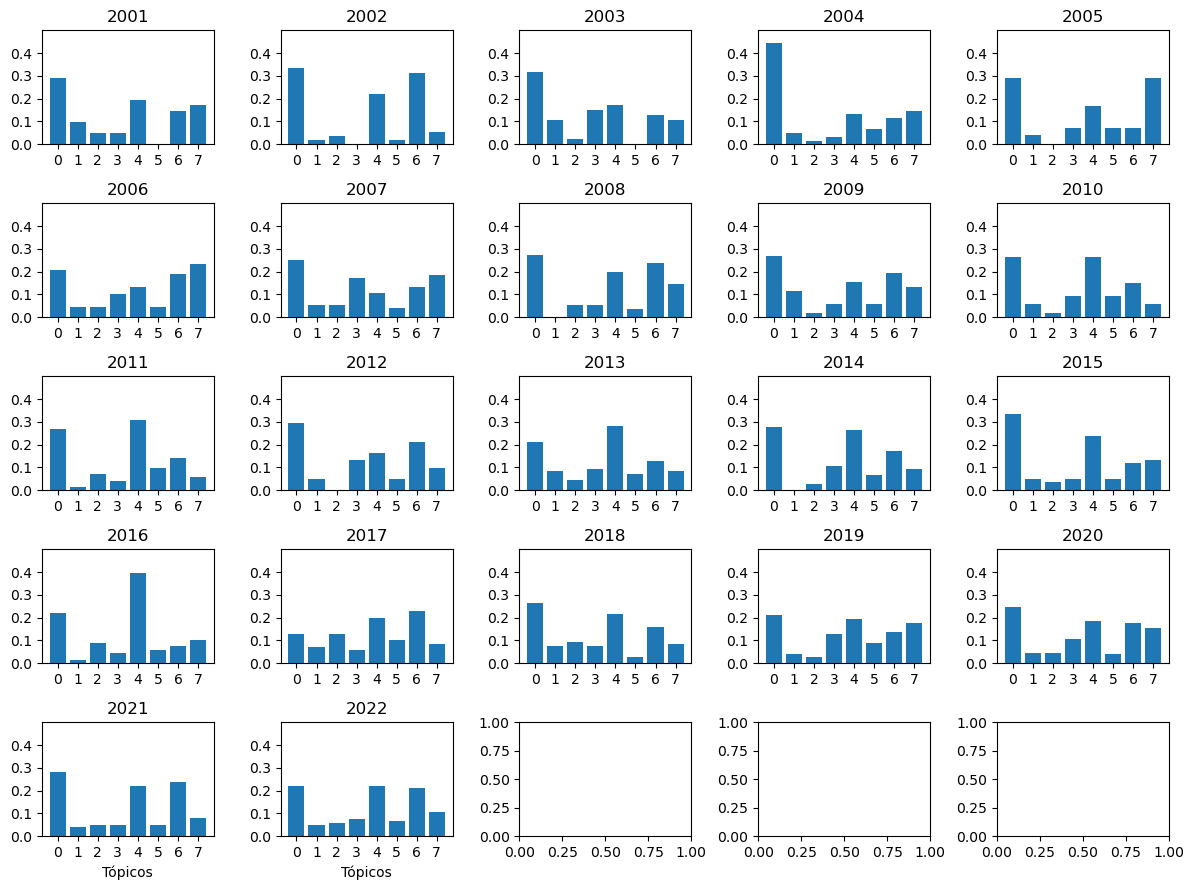

In [48]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                           figsize=(12, 9))
anos_sort = sorted(list(topicos_.keys()))
for ano in anos_sort:
    topicos = topicos_[ano]
    i, j = abs(ano - 2001)// 5, abs(ano - 2001)%5
    ax[i, j].set_title(f'{ano}')
    if i == 4:
        ax[i, j].set_xlabel('Tópicos')
    
    ax[i, j].bar(range(len(topicos)), np.array(topicos)/sum(topicos))
    ax[i, j].set_ylim(0, 0.5)
    ax[i, j].set_yticks([0,0.1, 0.2,0.3,0.4])
    ax[i, j].set_xticks(list(range(model.num_topics)))
    
fig.tight_layout()
plt.show()  

In [8]:
for i in dicionario:
    pal = dicionario[i]
    if len(pal) < 3:
        print(pal)

pé
ar
ga
má
vh
nu
li
rb
un
lo
le
sr
dr
hr
er
mh
pá
to
s
mc
co
im
tr
gí
wk
l
om
mi
hc
sa
br
bc
po
re
fã
pr
rã
r
ra
fp
cd
ão
pe
ta
si
eo
